In [8]:
import torch
from torch.utils.data import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# !pip install wandb
import wandb
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
print(torch.__version__)

2.0.1+cu118


In [9]:

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="transformer_timeseries",
)


In [10]:
'''
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/')


df=pd.read_csv('WTH.csv')
# df.drop('Unnamed: 0',axis=1,inplace=True)
df
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nimport os\nos.chdir('/content/drive/My Drive/')\n\n\ndf=pd.read_csv('WTH.csv')\n# df.drop('Unnamed: 0',axis=1,inplace=True)\ndf\n"

In [11]:
df=pd.read_csv('WTH.csv',index_col=None)
# df.drop('Unnamed: 0',axis=1,inplace=True)
df.iloc[:,1:]

,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,DewPointFarenheit,DewPointCelsius,RelativeHumidity,WindSpeed,WindDirection,StationPressure,Altimeter,WetBulbCelsius
0,10.0,16,-9,13,7,-14,67,7,130,21.650000,30.35,-10.3
1,10.0,16,-9,13,7,-14,67,5,150,21.640000,30.34,-10.3
2,10.0,16,-9,13,7,-14,67,5,190,21.650000,30.35,-10.3
3,10.0,16,-9,13,7,-14,67,7,180,21.650000,30.35,-10.3
4,10.0,16,-9,14,9,-13,74,6,120,21.640000,30.34,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,10.0,32,0,0,23,-5,0,0,0,21.478686,30.21,0.0
35060,7.0,30,-1,0,25,-4,0,5,110,21.478686,30.21,0.0
35061,5.0,30,-1,0,28,-2,0,0,0,21.478686,30.20,0.0
35062,10.0,30,-1,0,28,-2,0,5,140,21.478686,30.18,0.0


In [12]:
scaler = StandardScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
df

,date,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,DewPointFarenheit,DewPointCelsius,RelativeHumidity,WindSpeed,WindDirection,StationPressure,Altimeter,WetBulbCelsius
0,1/1/2010 0:00,0.301781,-1.580651,-1.605506,-1.632744,-1.014166,-1.035522,0.682362,0.278284,-0.025625,0.681993,0.652382,-1.641876
1,1/1/2010 1:00,0.301781,-1.580651,-1.605506,-1.632744,-1.014166,-1.035522,0.682362,-0.134472,0.170172,0.624802,0.608931,-1.641876
2,1/1/2010 2:00,0.301781,-1.580651,-1.605506,-1.632744,-1.014166,-1.035522,0.682362,-0.134472,0.561768,0.681993,0.652382,-1.641876
3,1/1/2010 3:00,0.301781,-1.580651,-1.605506,-1.632744,-1.014166,-1.035522,0.682362,0.278284,0.463869,0.681993,0.652382,-1.641876
4,1/1/2010 4:00,0.301781,-1.580651,-1.605506,-1.553935,-0.876306,-0.911101,0.960769,0.071906,-0.123524,0.624802,0.608931,-1.598387
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,12/31/2013 19:00,0.301781,-0.643255,-0.650163,-2.657250,0.088708,0.084264,-1.982391,-1.166361,-1.298311,-0.297782,0.044066,-0.148745
35060,12/31/2013 20:00,-1.172466,-0.760429,-0.756313,-2.657250,0.226567,0.208684,-1.982391,-0.134472,-0.221423,-0.297782,0.044066,-0.148745
35061,12/31/2013 21:00,-2.155297,-0.760429,-0.756313,-2.657250,0.433356,0.457525,-1.982391,-1.166361,-1.298311,-0.297782,0.000615,-0.148745
35062,12/31/2013 22:00,0.301781,-0.760429,-0.756313,-2.657250,0.433356,0.457525,-1.982391,-0.134472,0.072274,-0.297782,-0.086287,-0.148745


In [13]:
class weather_data(torch.utils.data.Dataset):
    def __init__(self, df, mode="train", seq_len=336, pred_len=96,num_feat=12):
        super().__init__()
        self.num_feat=num_feat
        self.df = df.iloc[:,1:num_feat+1]
        # time_stamp = df.iloc[:,0]

        assert mode in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[mode]

        self.seq_len = seq_len
        self.pred_len = pred_len
        dataset_len=len(df)

        border1s = [0, int(round(0.7*dataset_len,0)) - self.seq_len, int(round(0.7*dataset_len,0)) + int(round(0.1*dataset_len,0)) - self.seq_len]
        border2s = [int(round(0.7*dataset_len,0)), int(round(0.7*dataset_len,0)) + int(round(0.1*dataset_len,0)), int(round(0.7*dataset_len,0)) + int(round(0.1*dataset_len,0)) + int(round(0.2*dataset_len,0))]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]




        self.df = self.df.to_numpy(dtype=np.float32)
        # time_stamp = time_stamp.to_numpy()

        self.data_x = self.df[border1: border2, :]
        self.data_y = self.df[border1: border2, :]

        # self.data_stamp = time_stamp[border1: border2]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        return seq_x, seq_y


    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

In [14]:
from torch.utils.data import DataLoader

train_dataset = weather_data(df=df)
valid_dataset = weather_data(df=df,mode="val")
test_dataset = weather_data(df=df,mode="test")

print(len(train_dataset),len(valid_dataset),len(test_dataset))

24114 3411 6918


In [15]:
train_dataset[1][1].shape

(96, 12)

In [16]:
import os
current_directory = os.getcwd()
os.chdir(current_directory+r"\PatchTST\PatchTST_supervised")
from PatchTST.PatchTST_supervised.models.PatchTST import Model
os.chdir(current_directory)
Model

PatchTST.PatchTST_supervised.models.PatchTST.Model

In [17]:
class Configs:
    def __init__(self):
        self.enc_in = 12
        self.seq_len = 336
        self.pred_len = 96
        self.e_layers = 3
        self.n_heads = 4
        self.d_model = 16
        self.d_ff = 128
        self.dropout = 0.3
        self.fc_dropout = 0.
        self.head_dropout = 0.
        self.individual = True
        self.patch_len = 24
        self.stride = 2
        self.padding_patch = True
        self.revin = True
        self.affine = False
        self.subtract_last = False
        self.decomposition = False
        self.kernel_size = 25
        
my_configs = Configs()
model=Model(configs=my_configs)

In [18]:
dat=torch.from_numpy(train_dataset[0][0])
dat=dat.unsqueeze(dim=0)
dat.shape
model(dat).shape

torch.Size([1, 96, 12])

In [20]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [24]:
class model_run:
    def __init__(self,model=model):
        self.patchtst_model = model
        
    def model_architecture(self):
        n=0
        for x in self.patchtst_model.state_dict():
            n=n+1
            print(x)
        print("layers= ",n)

    def load_datasets(self,train_dataset=train_dataset,valid_dataset=valid_dataset,test_dataset=test_dataset):
        self.train_dataset=train_dataset
        self.valid_dataset=valid_dataset
        self.test_dataset=test_dataset



    def model_hyperparameters(self,batch_size=128,lr=0.00001,epochs=500,cuda=True,Dataloader=DataLoader):
        self.batch_size = batch_size
        self.lr=lr
        self.epochs=epochs

        self.train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=1, shuffle=False)
        self.valid_dataloader = DataLoader(self.valid_dataset, batch_size=batch_size, shuffle=True)


        if cuda:
            self.patchtst_model=self.patchtst_model.to("cuda")

        self.optimizer = torch.optim.Adam(self.patchtst_model.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()
        self.loss_mae=torch.nn.L1Loss()

    def model_execute(self,):
        self.load_datasets()
        self.model_hyperparameters()

        for epoch in range(self.epochs):
            iter_count = 0
            total_loss = 0
            train_steps=0
            total_train_mae_loss=0

            for train_x, train_y in tqdm(self.train_dataloader):
                train_x = train_x.to("cuda")
                train_y = train_y.to("cuda")
                
                self.i=train_x
                pred_y = self.patchtst_model(train_x)
                # print(train_x.shape)
                # print(train_y.shape)
                # print(pred_y.shape)
                train_mae_loss=self.loss_mae(pred_y, train_y)

                loss_t = self.loss(pred_y, train_y)
                self.optimizer.zero_grad()
                loss_t.backward()
                self.optimizer.step()
                total_loss += loss_t.item()
                total_train_mae_loss += train_mae_loss.item()
                iter_count += 1
                train_steps += 1

            valid_iter_count = 0
            valid_total_loss = 0
            valid_total_mae = 0
            with torch.no_grad():
                for valid_x, valid_y in self.valid_dataloader:
                    valid_x = valid_x.to("cuda")
                    valid_y = valid_y.to("cuda")
                    pred_y = self.patchtst_model(valid_x)
                    loss_v = self.loss(pred_y, valid_y)
                    valid_loss_mae=self.loss_mae(pred_y, valid_y)

                    valid_total_loss += loss_v.item()
                    valid_iter_count += 1

                    valid_total_mae+=valid_loss_mae.item()

                total_loss /= iter_count
                total_train_mae_loss /= iter_count

                valid_total_loss /= valid_iter_count
                valid_total_mae /= valid_iter_count
                wandb.log({"MSE Train": total_loss, "MSE Test": valid_total_loss,"MAE Train": total_train_mae_loss,"MAE Test": valid_total_mae})

                print("epoch: {} MSE loss: {:.4f} MSE valid loss: {:.4f}".format(epoch, total_loss, valid_total_loss))
                print("          MAE loss: {:.4f} MAE valid loss: {:.4f}".format(total_train_mae_loss, valid_total_mae))

    def save_model(self,name):
        torch.save(self.patchtst_model.state_dict(), name+'.pth')


    def test_plots(self,ind=3,df_columns=None,scaler=None,column=None):
        test_total_loss = 0
        test_total_loss_mae=0
        test_iter_count = 0
        test_pred_plot=[]
        test_y_plot=[]
        
        df_y_final=pd.DataFrame(columns=df_columns)
        df_pred_final=pd.DataFrame(columns=df_columns)
        
        for test_x, test_y in self.test_dataloader:
            test_x = test_x.to("cuda")
            test_y = test_y.to("cuda")
            test_pred=self.patchtst_model(test_x.to("cuda"))
            # print(test_pred.shape)
            # print(test_y.shape)
            loss_test=self.loss(test_pred, test_y)
            test_total_loss += loss_test.item()
            
            loss_test_mae=self.loss_mae(test_pred, test_y)
            test_total_loss_mae+=loss_test_mae.item()
            
            test_iter_count += 1
              
            df_y=pd.DataFrame(test_y[0].to("cpu").numpy(),columns=df_columns)
            df_pred=pd.DataFrame(test_pred[0].to("cpu").detach().numpy(),columns=df_columns)
            
            df_y_final = pd.concat([df_y_final, df_y], axis=0)
            df_pred_final = pd.concat([df_pred_final, df_pred], axis=0)
        df_pred_final=scaler.inverse_transform(df_pred_final)   
        df_y_final=scaler.inverse_transform(df_y_final)
        
        df_pred_final=pd.DataFrame(df_pred_final,columns=df_columns)
        df_y_final=pd.DataFrame(df_y_final,columns=df_columns)
        
        
        sns.lineplot(x=list(range(len(df_pred_final)))[:96], y=df_pred_final[column][:96], label="predicted")
        sns.lineplot(x=list(range(len(df_y_final)))[:96], y=df_y_final[column][:96], label="actual")
        plt.legend(title='Type')
        plt.xlabel('Time Step')
        plt.title("Predicted vs Actual")
        plt.show()
        
        
        test_total_loss/= test_iter_count
        test_total_loss_mae/=test_iter_count
        print("MSE test loss: ",test_total_loss)
        print("MAE test loss: ",test_total_loss_mae)
         
'''
            # plotting
            
            for i,j in zip(test_pred[0],test_y[0]):
                pass
            # print(i[ind].item())
                test_pred_plot.append(i[ind].item())
            # print(j[ind].item())
                test_y_plot.append(j[ind].item())
        sns.lineplot(x=list(range(len(test_pred_plot)))[:96], y=test_pred_plot[:96], label="predicted")
        sns.lineplot(x=list(range(len(test_y_plot)))[:96], y=test_y_plot[:96], label="actual")
        plt.legend(title='Lines')
        plt.show()
        test_total_loss/= test_iter_count
        print("MSE test loss: ",test_total_loss)

        '''


'\n            # plotting\n            \n            for i,j in zip(test_pred[0],test_y[0]):\n                pass\n            # print(i[ind].item())\n                test_pred_plot.append(i[ind].item())\n            # print(j[ind].item())\n                test_y_plot.append(j[ind].item())\n        sns.lineplot(x=list(range(len(test_pred_plot)))[:96], y=test_pred_plot[:96], label="predicted")\n        sns.lineplot(x=list(range(len(test_y_plot)))[:96], y=test_y_plot[:96], label="actual")\n        plt.legend(title=\'Lines\')\n        plt.show()\n        test_total_loss/= test_iter_count\n        print("MSE test loss: ",test_total_loss)\n\n        '

In [25]:
x=model_run(model=model)

In [26]:
x.model_execute()

  1%|▊                                                                                 | 2/189 [00:06<10:30,  3.37s/it]


KeyboardInterrupt: 

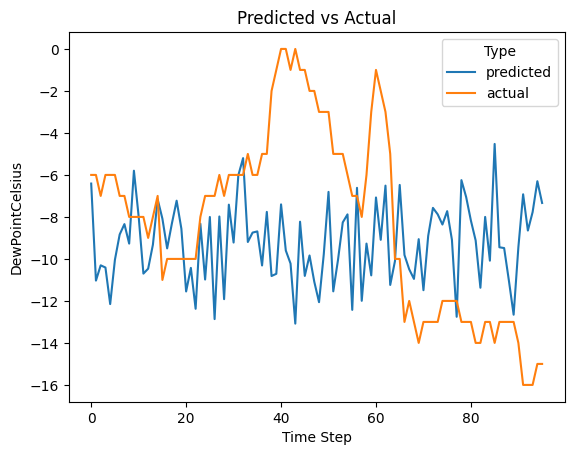

MSE test loss:  0.649642786452125
MAE test loss:  0.5840984666561178


In [27]:
x.test_plots(df_columns=df.columns[1:],scaler=scaler,column='DewPointCelsius')

In [320]:
'''
dat=torch.from_numpy(train_dataset[0][0])
dat=dat.unsqueeze(dim=0)
dat.shape
model(dat).shape
'''

'\ndat=torch.from_numpy(train_dataset[0][0])\ndat=dat.unsqueeze(dim=0)\ndat.shape\nmodel(dat).shape\n'